[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/williamyang1991/StyleGANEX/blob/master/inference_playground.ipynb)

In [ ]:
!pip install gradio huggingface_hub

In [3]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "0"
os.chdir('../')
CODE_DIR  = 'StyleGANEX'
device = 'cuda'

In [ ]:
!git clone https://github.com/williamyang1991/StyleGANEX.git $CODE_DIR
os.chdir(f'./{CODE_DIR}')

In [5]:
%load_ext autoreload
%autoreload 2

from models.psp import pSp
from models.bisenet.model import BiSeNet

import torch
import dlib
import cv2
import PIL
from tqdm import tqdm
import numpy as np
import torch.nn.functional as F
import torchvision
from torchvision import transforms, utils
from argparse import Namespace
from datasets import augmentations
from huggingface_hub import hf_hub_download
from scripts.align_all_parallel import align_face
from latent_optimization import latent_optimization
from utils.inference_utils import save_image, load_image, visualize, get_video_crop_parameter, tensor2cv2, tensor2label, labelcolormap

In [7]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],std=[0.5,0.5,0.5]),
    ])

In [8]:
landmarkpredictor = dlib.shape_predictor(huggingface_hub.hf_hub_download('PKUWilliamYang/VToonify', 
                                                                         'models/shape_predictor_68_face_landmarks.dat'))

In [9]:
parameters = {}

parameters['inversion'] = {'path':'pretrained_models/styleganex_inversion.pt', 'image_path':'./data/ILip77SbmOE.jpg'}
parameters['sr-32'] = {'path':'pretrained_models/styleganex_sr32.pt', 'image_path':'./data/pexels-daniel-xavier-1239291.jpg'}
parameters['sr'] = {'path':'pretrained_models/styleganex_sr.pt', 'image_path':'./data/pexels-daniel-xavier-1239291.jpg'}
parameters['sketch2face'] = {'path':'pretrained_models/styleganex_sketch2face.pt', 'image_path':'./data/234_sketch.jpg'}
parameters['mask2face'] = {'path':'pretrained_models/styleganex_mask2face.pt', 'image_path':'./data/540.jpg'}
parameters['edit_age'] = {'path':'pretrained_models/styleganex_edit_age.pt', 'image_path':'./data/390.mp4'}
parameters['edit_hair'] = {'path':'pretrained_models/styleganex_edit_hair.pt', 'image_path':'./data/390.mp4'}
parameters['toonify_pixar'] = {'path':'pretrained_models/styleganex_toonify_pixar.pt', 'image_path':'./data/pexels-anthony-shkraba-production-8136210.mp4'}
parameters['toonify_cartoon'] = {'path':'pretrained_models/styleganex_toonify_cartoon.pt', 'image_path':'./data/pexels-anthony-shkraba-production-8136210.mp4'}
parameters['toonify_arcane'] = {'path':'pretrained_models/styleganex_toonify_arcane.pt', 'image_path':'./data/pexels-anthony-shkraba-production-8136210.mp4'}

In [10]:
%matplotlib inline

In [1]:
def load_model(path, device):
    ckpt = torch.load(hf_hub_download('PKUWilliamYang/StyleGANEX', path), map_location='cpu')
    opts = ckpt['opts']
    opts['checkpoint_path'] = path
    opts = Namespace(**opts)
    pspex = pSp(opts).to(device).eval()
    pspex.latent_avg = pspex.latent_avg.to(device)
    return pspex

# Task Index
Click to skip to the corresponding task
- [Face Inversion](#inv)
- [Face Super Resolution](#sr)
- [Sketch-to-Face Translation](#s2f)
- [Mask-to-Face Translation](#m2f)
- [Video Face Editing](#video_editing)
- [Video Face Toonification](#toonify)

# Face Inversion
<a id='inv'></a>

We will download the pre-trained model to perform StyleGANEX inversion,
and perform style mixing and domain transfer to this embedded image.
- Style mixing: applying random color and texture to the target image
- Domain transfer: load a StyleGAN-NADA model to generate stylized image

In [2]:
task = 'inversion'

In [ ]:
path = parameters[task]['path']
pspex = load_model(task, device)

In [18]:
image_path = parameters[task]['image_path'] # change image_path to your image
with torch.no_grad():
    frame = cv2.imread(image_path)
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    paras = get_video_crop_parameter(frame, landmarkpredictor)
    
    h,w,top,bottom,left,right,scale = paras
    H, W = int(bottom-top), int(right-left)
    frame = cv2.resize(frame, (w, h))[top:bottom, left:right]

In [21]:
wplus_hat, f_hat, noises_hat, wplus, f = latent_optimization(frame, pspex, landmarkpredictor, step=500, device=device)

Setting up Perceptual loss...
Loading model from: /mnt/lustre/syang/code/StyleGAN_related/styleganex/models/stylegan2/lpips/weights/v0.1/vgg.pth
...[net-lin [vgg]] initialized
...Done


  0%|          | 0/500 [00:00<?, ?it/s]/mnt/lustre/syang/anaconda3/envs/psp_env/lib/python3.8/site-packages/torch/nn/functional.py:3060: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn("Default upsampling behavior when mode={} is changed "
/mnt/lustre/syang/anaconda3/envs/psp_env/lib/python3.8/site-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
perceptual: 0.06

In [22]:
with torch.no_grad():
    y_init, _ = pspex.decoder([wplus], input_is_latent=True, first_layer_feature=f)
    y_hat, _ = pspex.decoder([wplus_hat], input_is_latent=True, randomize_noise=False, 
                                 first_layer_feature=f_hat, noise=noises_hat)
    y = F.interpolate(transform(frame).unsqueeze(dim=0).to(device), scale_factor=4)    

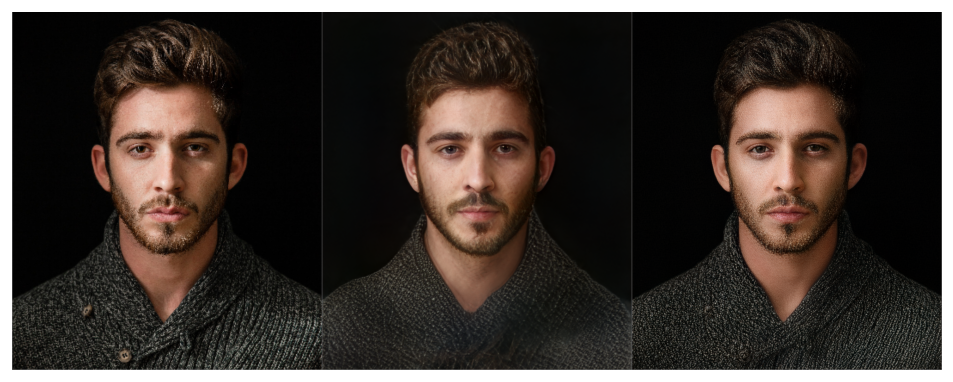

In [23]:
viz = torchvision.utils.make_grid(torch.clamp(torch.cat([y, y_init, y_hat], dim=0), -1, 1), 3, 2)   
visualize(viz, 120)

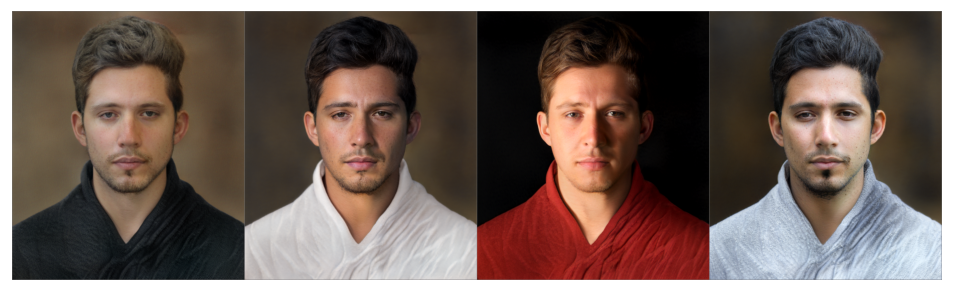

In [24]:
# style mixing
torch.manual_seed(32)
y_hats = []
with torch.no_grad():
    for j in range(4):
        mixed_style = pspex.decoder.style(torch.randn(1, 512).cuda()).unsqueeze(1).repeat(1,18,1) * 0.6
        mixed_style[:,0:8] = wplus_hat[:,0:8]
        y_hat, _ = pspex.decoder([mixed_style], input_is_latent=True, randomize_noise=False, 
                                     first_layer_feature=f_hat, noise=noises_hat)        
        y_hat = torch.clamp(y_hat, -1, 1)
        y_hats += [y_hat]

viz = torchvision.utils.make_grid(torch.cat(y_hats, dim=0), 5, 2)   
visualize(viz, 120)

In [ ]:
# domain transfer

In [25]:
model_repos = {"pixar": ("rinong/stylegan-nada-models", "pixar.pt"),
               "disney_princess": ("rinong/stylegan-nada-models", "disney_princess.pt"),
               "edvard_munch": ("rinong/stylegan-nada-models", "edvard_munch.pt"),
               "vintage_comics": ("rinong/stylegan-nada-models", "vintage_comics.pt"),
               "modigliani": ("rinong/stylegan-nada-models", "modigliani.pt")}

In [37]:
domain = 'vintage_comics'
stylegannada = hf_hub_download(model_repos[domain][0],model_repos[domain][1])
pspex.decoder.load_state_dict(torch.load(stylegannada, map_location='cpu')['g_ema'], strict=False)
pspex.decoder.to(device)

with torch.no_grad():
    y_hat, _ = pspex.decoder([wplus_hat], input_is_latent=True, randomize_noise=False, 
                                 first_layer_feature=f_hat, noise=noises_hat)
    y = F.interpolate(transform(frame).unsqueeze(dim=0).to(device), scale_factor=4) 

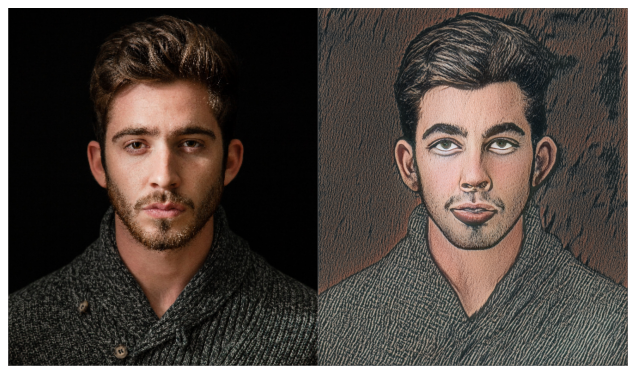

In [38]:
viz = torchvision.utils.make_grid(torch.clamp(torch.cat([y, y_hat], dim=0), -1, 1), 3, 2)   
visualize(viz, 80)    

# Face Super Resolution
<a id='sr'></a>

We will download the pre-trained models to perform face super resolution on two settings:
- Specific SR: SR with a specific model trained on 32x SR
- General SR: SR with a model trained on 4x-48x SR

Perform 32x face super resolution 

In [8]:
task = 'sr-32'

In [9]:
path = parameters[task]['path']
pspex = load_model(task, device)

In [65]:
image_path = parameters[task]['image_path'] # change image_path to your image
with torch.no_grad():
    frame = cv2.imread(image_path)
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    paras = get_video_crop_parameter(frame, landmarkpredictor)
    
    h,w,top,bottom,left,right,scale = paras
    H, W = int(bottom-top), int(right-left)
    frame = cv2.resize(frame, (w, h))[top:bottom, left:right]
    #x2 = align_face(frame, landmarkpredictor)
    
    x1 = PIL.Image.fromarray(np.uint8(frame))
    x1 = augmentations.BilinearResize(factors=[8])(x1)
    x1_up = x1.resize((W, H))
    x2_up = align_face(np.array(x1_up), landmarkpredictor)
    
    x1_up = transforms.ToTensor()(x1_up).unsqueeze(dim=0).to(device) * 2 - 1
    x2_up = transform(x2_up).unsqueeze(dim=0).to(device)
    print('Input image size:', x1.size)
    
    y_hat = torch.clamp(pspex(x1=x1_up, x2=x2_up, use_skip=pspex.opts.use_skip, resize=False), -1, 1)
    print('Output image size:', y_hat.shape[2:])

Input image size: (50, 50)
Output image size: torch.Size([1600, 1600])


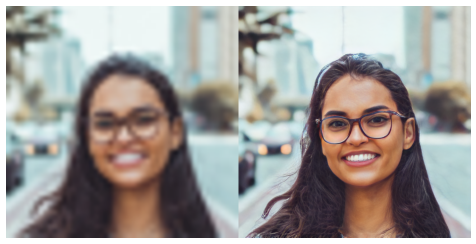

In [66]:
visualize(torch.cat((F.interpolate(x1_up, scale_factor=4)[0].cpu(), y_hat[0].cpu()), dim=2), 60)

In [87]:
#save the result to files
#save_image(y_hat[0].cpu(), './output/%s_sr.jpg'%(os.path.basename(image_path).split('.')[0]))

Perform 16x, 32x and 48x face super resolution with a single model

In [67]:
task = 'sr'

In [77]:
path = parameters[task]['path']
pspex = load_model(task, device)

Input image size: (100, 100)
Output image size: torch.Size([1600, 1600])


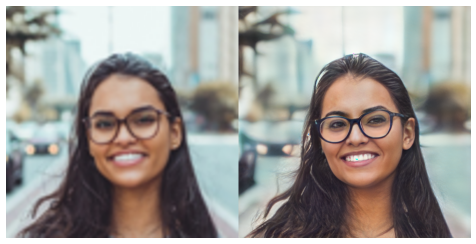

Input image size: (50, 50)
Output image size: torch.Size([1600, 1600])


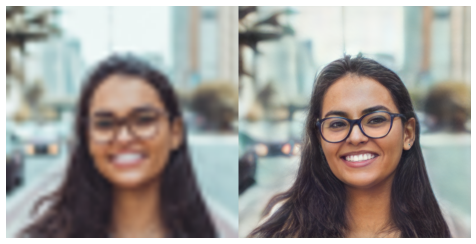

Input image size: (33, 33)
Output image size: torch.Size([1600, 1600])


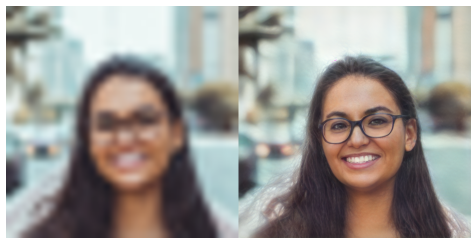

In [84]:
image_path = parameters[task]['image_path'] # change image_path to your image
with torch.no_grad():
    frame = cv2.imread(image_path)
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    paras = get_video_crop_parameter(frame, landmarkpredictor)
    
    h,w,top,bottom,left,right,scale = paras
    H, W = int(bottom-top), int(right-left)
    frame = cv2.resize(frame, (w, h))[top:bottom, left:right]
    #x2 = align_face(frame, landmarkpredictor)
    for i in [4,8,12]:
        x1 = PIL.Image.fromarray(np.uint8(frame))
        x1 = augmentations.BilinearResize(factors=[i])(x1)
        x1_up = x1.resize((W, H))
        x2_up = align_face(np.array(x1_up), landmarkpredictor)

        x1_up = transforms.ToTensor()(x1_up).unsqueeze(dim=0).to(device) * 2 - 1
        x2_up = transform(x2_up).unsqueeze(dim=0).to(device)
        print('Input image size:', x1.size)

        y_hat = torch.clamp(pspex(x1=x1_up, x2=x2_up, use_skip=pspex.opts.use_skip, resize=False), -1, 1)
        print('Output image size:', y_hat.shape[2:])
        
        visualize(torch.cat((F.interpolate(x1_up, scale_factor=4)[0].cpu(), y_hat[0].cpu()), dim=2), 60)

# Sketch2Face
<a id='s2f'></a>

We will download the pre-trained model to perform sketch-to-face translation,
and perform style mixing for multi-modal translation.
- Input: should be a one-channel sketch image
- Style mixing: applying random color and texture to the target image

In [97]:
task = 'sketch2face'

In [109]:
path = parameters[task]['path']
pspex = load_model(task, device)

Loading pSp from checkpoint: pretrained_models/styleganex_sketch2face.pt


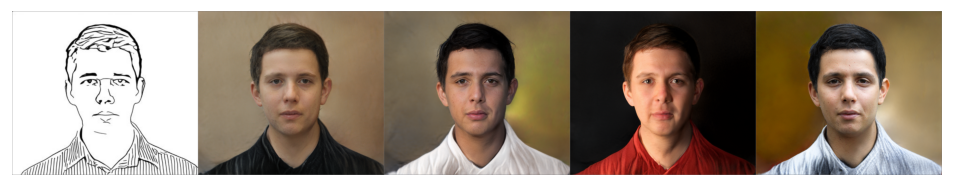

In [134]:
image_path = parameters[task]['image_path'] # change image_path to your image
torch.manual_seed(32)
with torch.no_grad():
    x1 = transforms.ToTensor()(PIL.Image.open(image_path)).unsqueeze(0).to(device)
    x1_viz = torch.clamp(x1.repeat(1,3,1,1), -1, 1) * 2 - 1
    pspex.train()
    y_hats = [F.interpolate(x1_viz, scale_factor=4)]
    # randomly sample four style appearances 
    for j in range(4):
        y_hat = pspex(x1=x1, resize=False, latent_mask=[8,9,10,11,12,13,14,15,16,17], use_skip=pspex.opts.use_skip,
                              inject_latent= pspex.decoder.style(torch.randn(1, 512).cuda()).unsqueeze(1).repeat(1,18,1) * 0.6)  
        y_hat = torch.clamp(y_hat, -1, 1)
        y_hats += [y_hat]
    pspex.eval()

viz = torchvision.utils.make_grid(torch.cat(y_hats, dim=0), 5, 2)   
visualize(viz, 120)

# Mask2Face
<a id='m2f'></a>

We will download the pre-trained model to perform mask-to-face translation,
and perform style mixing for multi-modal translation.
- Input: should be a real face image. We will extract its segmentation mask as the input
- Style mixing: applying random color and texture to the target image

In [156]:
task = 'mask2face'

In [157]:
path = parameters[task]['path']
pspex = load_model(task, device)

Loading pSp from checkpoint: pretrained_models/styleganex_mask2face.pt


In [138]:
maskpredictor = BiSeNet(n_classes=19)
maskpredictor.load_state_dict(torch.load(huggingface_hub.hf_hub_download('PKUWilliamYang/VToonify', 'models/faceparsing.pth'),
                                            map_location='cpu'))
maskpredictor.to(device).eval()

to_tensor = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

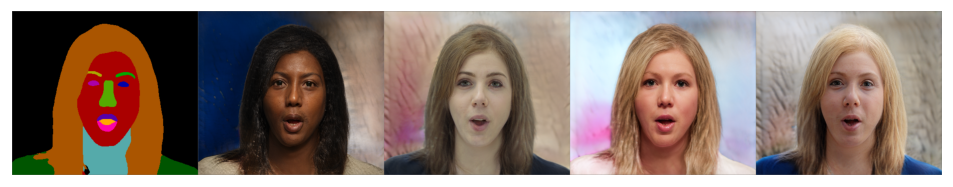

In [207]:
image_path = parameters[task]['image_path'] # change image_path to your image
torch.manual_seed(2)
with torch.no_grad():
    # convert face image to segmentation mask
    x1 = to_tensor(PIL.Image.open(image_path)).unsqueeze(0).to(device)
    # upsample image for precise segmentation
    x1 = F.interpolate(x1, scale_factor=2, mode='bilinear') 
    x1 = maskpredictor(x1)[0]
    x1 = F.interpolate(x1, scale_factor=0.5).argmax(dim=1)
    x1 = F.one_hot(x1, num_classes=19).permute(0, 3, 1, 2).float().to(device)
    x1_viz = transform(tensor2label(x1[0], 19)/192).unsqueeze(0).to(device)    
    
    pspex.train()
    y_hats = [F.interpolate(x1_viz, scale_factor=4)]
    # randomly sample four style appearances 
    for j in range(4):
        y_hat = pspex(x1=x1, resize=False, latent_mask=[8,9,10,11,12,13,14,15,16,17], use_skip=pspex.opts.use_skip,
                              inject_latent= pspex.decoder.style(torch.randn(1, 512).cuda()).unsqueeze(1).repeat(1,18,1) * 0.75)  
        y_hat = torch.clamp(y_hat, -1, 1)
        y_hats += [y_hat]
    pspex.eval()

viz = torchvision.utils.make_grid(torch.cat(y_hats, dim=0), 5, 2)   
visualize(viz, 120)

# Video Face Editing
<a id='video_editing'></a>

We will download the pre-trained model to perform two video face editings.
- Hair editing: control color on a single frame, and adjust the hair color on multiple frames
- Age editing: control age on a single frame, and adjust the age on multiple frames

Hair color editing

In [260]:
task = 'edit_hair'

In [262]:
path = parameters[task]['path']
pspex = load_model(task, device)
editing_w = ckpt['editing_w'].clone().to(device)

Loading pSp from checkpoint: pretrained_models/styleganex_edit_hair.pt


In [281]:
image_path = parameters[task]['image_path'] # change image_path to your image
video_cap = cv2.VideoCapture(image_path)
success, frame = video_cap.read()
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

paras = get_video_crop_parameter(frame, landmarkpredictor)
h,w,top,bottom,left,right,scale = paras
H, W = int(bottom-top), int(right-left)
frame = cv2.resize(frame, (w, h))[top:bottom, left:right]

x1 = transform(frame).unsqueeze(0).to(device)
with torch.no_grad():
    x2 = align_face(frame, landmarkpredictor)
    x2 = transform(x2).unsqueeze(dim=0).to(device)

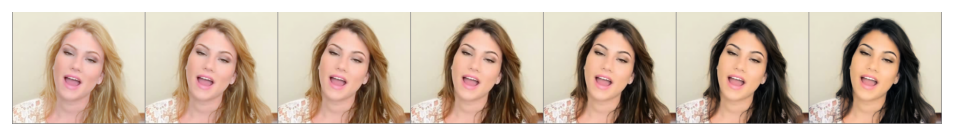

In [282]:
# color control on the fisrt frame
y_hats = []
with torch.no_grad():
    for i in tqdm(range(7)):
        y_hat = pspex(x1=x1, x2=x2, use_skip=pspex.opts.use_skip, zero_noise=True, 
                        resize=False, editing_w=2*(-0.5 + i/6.0)*editing_w[0:1])
        y_hat = torch.clamp(y_hat, -1, 1)
        y_hats+=[y_hat.cpu()]
        
viz = torchvision.utils.make_grid(torch.cat(y_hats, dim=0), 7, 2)
visualize(viz, 120)

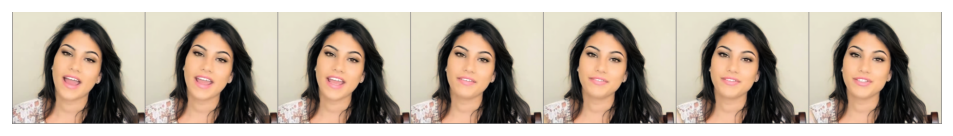

In [283]:
# a fixed hair color on multiple frames

# uncomment the following lines to save the video
# fourcc = cv2.VideoWriter_fourcc(*'mp4v')
# videoWriter = cv2.VideoWriter('./output/%s_edit_hair.mp4'%(os.path.basename(image_path).split('.')[0]), fourcc, video_cap.get(5), (4*W, 4*H))
               
y_hats = []
with torch.no_grad():
    for i in tqdm(range(7)):
        success, frame = video_cap.read()
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame = cv2.resize(frame, (w, h))[top:bottom, left:right]
        x1 = transform(frame).unsqueeze(0).to(device)
        y_hat = pspex(x1=x1, x2=x2, use_skip=pspex.opts.use_skip, zero_noise=True, 
                       resize=False, editing_w=editing_w[0:1])
        y_hat = torch.clamp(y_hat, -1, 1)
        #videoWriter.write(tensor2cv2(y_hat[0].cpu()))
        y_hats+=[y_hat.cpu()]        
#videoWriter.release()

viz = torchvision.utils.make_grid(torch.cat(y_hats, dim=0), 7, 2)
visualize(viz, 120)

Age editing

In [284]:
task = 'edit_age'

In [285]:
path = parameters[task]['path']
pspex = load_model(task, device)
editing_w = ckpt['editing_w'].clone().to(device)

Loading pSp from checkpoint: pretrained_models/styleganex_edit_age.pt


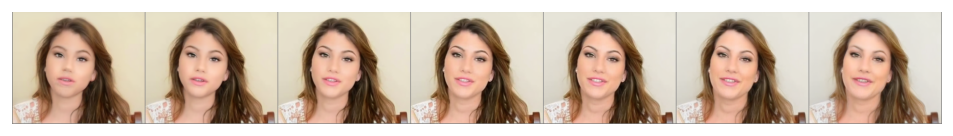

In [286]:
# age control on the fisrt frame
y_hats = []
with torch.no_grad():
    for i in tqdm(range(7)):
        y_hat = pspex(x1=x1, x2=x2, use_skip=pspex.opts.use_skip, zero_noise=True, 
                       resize=False, editing_w=5*(-0.5 + i/6.0)*editing_w[0:1])
        y_hat = torch.clamp(y_hat, -1, 1)
        y_hats+=[y_hat.cpu()]
        
viz = torchvision.utils.make_grid(torch.cat(y_hats, dim=0), 7, 2)
visualize(viz, 120)

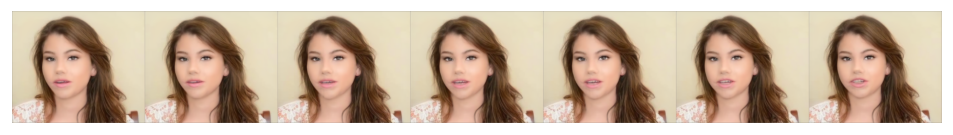

In [291]:
# a fixed age on multiple frames

# uncomment the following lines to save the video
# fourcc = cv2.VideoWriter_fourcc(*'mp4v')
# videoWriter = cv2.VideoWriter('./output/%s_edit_age.mp4'%(os.path.basename(image_path).split('.')[0]), fourcc, video_cap.get(5), (4*W, 4*H))
               
y_hats = []
with torch.no_grad():
    for i in tqdm(range(7)):
        success, frame = video_cap.read()
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame = cv2.resize(frame, (w, h))[top:bottom, left:right]
        x1 = transform(frame).unsqueeze(0).to(device)
        y_hat = pspex(x1=x1, x2=x2, use_skip=pspex.opts.use_skip, zero_noise=True, 
                       resize=False, editing_w=-2.5*editing_w[0:1])
        y_hat = torch.clamp(y_hat, -1, 1)
        #videoWriter.write(tensor2cv2(y_hat[0].cpu()))
        y_hats+=[y_hat.cpu()]        
#videoWriter.release()

viz = torchvision.utils.make_grid(torch.cat(y_hats, dim=0), 7, 2)
visualize(viz, 120)

# Video Face Toonification
<a id='toonify'></a>

We will download the pre-trained model to perform vidoe face toonification. Three styles are supported: 
- Pixar
- Cartoon
- Arcane

In [303]:
# choose different style type

task = 'toonify_pixar'
#task = 'toonify_cartoon'
#task = 'toonify_arcane'

In [304]:
path = parameters[task]['path']
pspex = load_model(task, device)

Loading pSp from checkpoint: pretrained_models/styleganex_toonify_cartoon.pt


In [296]:
image_path = parameters[task]['image_path'] # change image_path to your image
video_cap = cv2.VideoCapture(image_path)
success, frame = video_cap.read()
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

paras = get_video_crop_parameter(frame, landmarkpredictor)
h,w,top,bottom,left,right,scale = paras
H, W = int(bottom-top), int(right-left)
frame = cv2.resize(frame, (w, h))[top:bottom, left:right]

x1 = transform(frame).unsqueeze(0).to(device)
with torch.no_grad():
    x2 = align_face(frame, landmarkpredictor)
    x2 = transform(x2).unsqueeze(dim=0).to(device)

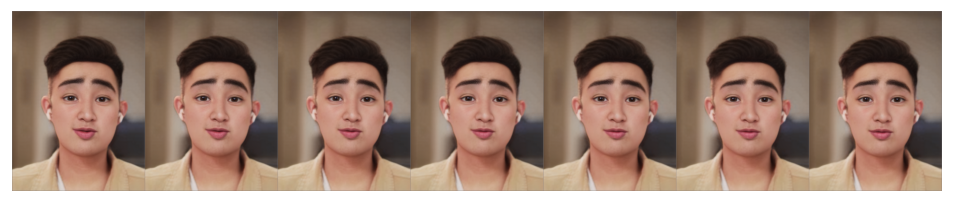

In [305]:
# uncomment the following lines to save the video
# fourcc = cv2.VideoWriter_fourcc(*'mp4v')
# videoWriter = cv2.VideoWriter('./output/%s_edit_hair.mp4'%(os.path.basename(image_path).split('.')[0]), fourcc, video_cap.get(5), (4*W, 4*H))
               
y_hats = []
with torch.no_grad():
    for i in tqdm(range(7)):
        success, frame = video_cap.read()
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame = cv2.resize(frame, (w, h))[top:bottom, left:right]
        x1 = transform(frame).unsqueeze(0).to(device)
        y_hat = pspex(x1=x1, x2=x2, use_skip=pspex.opts.use_skip, zero_noise=True, resize=False)
        y_hat = torch.clamp(y_hat, -1, 1)
        #videoWriter.write(tensor2cv2(y_hat[0].cpu()))
        y_hats+=[y_hat.cpu()]        
#videoWriter.release()

viz = torchvision.utils.make_grid(torch.cat(y_hats, dim=0), 7, 2)
visualize(viz, 120)